保留 95% 方差所需 PCA 维度数: 9
Accuracy with LDA: 0.82
Accuracy with PCA (自动维度=9): 0.84
Accuracy without LDA or PCA: 0.80


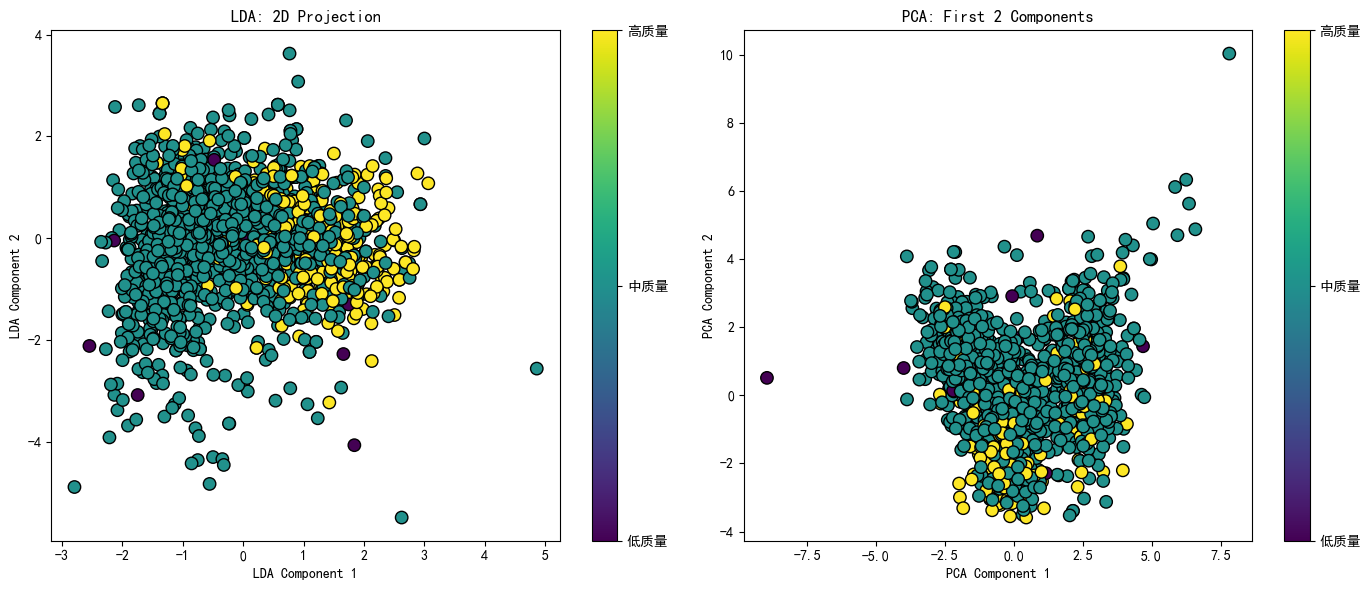

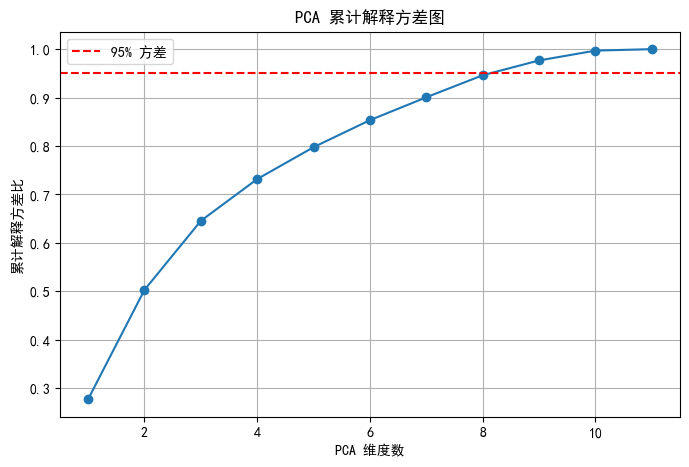

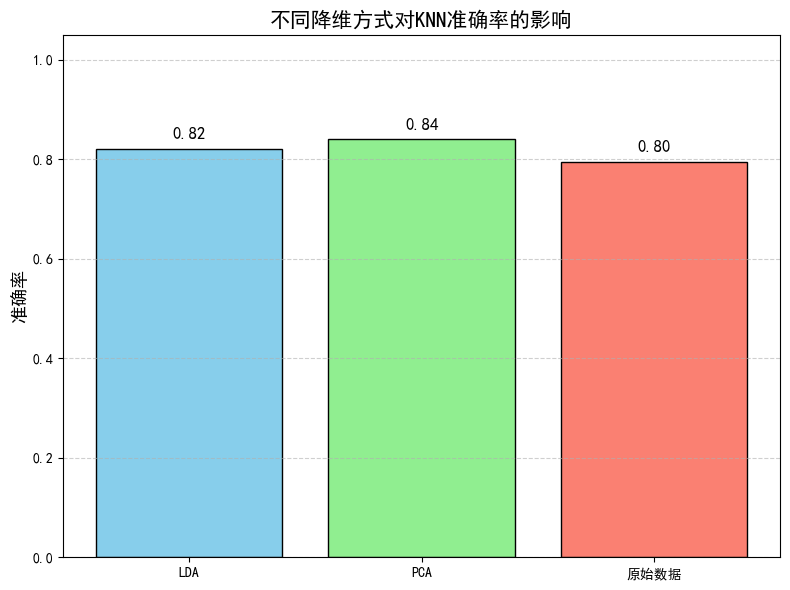

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import Normalize
import matplotlib

# 中文设置
norm = Normalize(vmin=0, vmax=2)
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. 获取 Wine Quality 数据集
wine_quality = fetch_ucirepo(id=186)
X = np.array(wine_quality.data.features)
y = np.array(wine_quality.data.targets).flatten()

# 2. 将质量评分转换为三类标签
y = np.where(y < 4, 0, np.where(y < 7, 1, 2))

# 3. 划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. 标准化用于 PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. 寻找保留95%方差的PCA维度数
pca_full = PCA()
pca_full.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"保留 95% 方差所需 PCA 维度数: {n_components_95}")

# 6. 使用 PCA 降维
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 7. 使用 LDA 降维
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# 8. 使用 KNN 进行训练与预测
knn_lda = KNeighborsClassifier(n_neighbors=3).fit(X_train_lda, y_train)
knn_pca = KNeighborsClassifier(n_neighbors=3).fit(X_train_pca, y_train)
knn_raw = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

# 9. 评估准确率
accuracy_lda = accuracy_score(y_test, knn_lda.predict(X_test_lda))
accuracy_pca = accuracy_score(y_test, knn_pca.predict(X_test_pca))
accuracy_raw = accuracy_score(y_test, knn_raw.predict(X_test))

print(f"Accuracy with LDA: {accuracy_lda:.2f}")
print(f"Accuracy with PCA (自动维度={n_components_95}): {accuracy_pca:.2f}")
print(f"Accuracy without LDA or PCA: {accuracy_raw:.2f}")

# 10. 可视化 LDA 和 PCA 降维结果
plt.figure(figsize=(14, 6))

# LDA 可视化
plt.subplot(1, 2, 1)
scatter_lda = plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1],
                          c=y_test, cmap='viridis', edgecolor='k', s=80)
plt.title("LDA: 2D Projection")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
cbar_lda = plt.colorbar(scatter_lda, ticks=[0, 1, 2])
cbar_lda.ax.set_yticklabels(['低质量', '中质量', '高质量'])

# PCA 可视化
plt.subplot(1, 2, 2)
scatter_pca = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1],
                          c=y_test, cmap='viridis', edgecolor='k', s=80)
plt.title("PCA: First 2 Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
cbar_pca = plt.colorbar(scatter_pca, ticks=[0, 1, 2])
cbar_pca.ax.set_yticklabels(['低质量', '中质量', '高质量'])

plt.tight_layout()
plt.savefig("LDA与PCA投影可视化.png", dpi=300)
plt.show()

# 11. PCA 累计解释方差图
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% 方差')
plt.xlabel("PCA 维度数")
plt.ylabel("累计解释方差比")
plt.title("PCA 累计解释方差图")
plt.grid(True)
plt.legend()
plt.savefig("PCA累计解释方差图.png", dpi=300)
plt.show()

# 12. 模型准确率对比柱状图
plt.figure(figsize=(8, 6))
models = ['LDA', 'PCA', '原始数据']
accuracies = [accuracy_lda, accuracy_pca, accuracy_raw]
colors = ['skyblue', 'lightgreen', 'salmon']

bars = plt.bar(models, accuracies, color=colors, edgecolor='black')

# 添加准确率文本
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.015,
             f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1.05)
plt.title('不同降维方式对KNN准确率的影响', fontsize=15)
plt.ylabel('准确率', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("模型准确率对比.png", dpi=300)
plt.show()
